# Non-stationary heat transfer in a plate with anisotropy general view under the influence of impulse heat sources
The thermophysical characteristics of many solids (for example, crystals, composite materials) are characterized by anisotropy, i.e. their properties are different in different directions. In this case, the thermal conductivity is not a scalar, but a symmetric tensor of the second rank:

\begin{equation}
\hat{\lambda} =
\begin{pmatrix}
\lambda_{11} & \lambda_{12} \\
\lambda_{21} & \lambda_{22}
\end{pmatrix},
\end{equation}

where $\lambda_{12} = \lambda_{21}$. The equation also contains mixed derivatives. Then for the plate $[-0.1,0.1]\times[0,0.1]$ meters in coordinate notation we will have the following heat equation:

\begin{equation}
c\rho\dfrac{\partial T}{\partial t} = \lambda_{11}\dfrac{\partial^2 T}{\partial x^2} + 2\lambda_{12}\dfrac{\partial^2 T}{\partial x \partial y} +\lambda_{22}\dfrac{\partial^2 T}{\partial y^2}, \; -0.1 < x < 0.1, \; 0 < y < 0.1, \; t > 0.
\end{equation}

Let arbitrary thermal impulse heat sources $q_1(x)$ and $q_2(x)$ applied at points $\xi_1=0.025$ and $\xi_2=-0.025$ act on the boundaries $y=0$ and $y=0.1$ of an anisotropic plate. The numerical solution requires the smoothness of the functions, so we simulate pulsed heating with an exponential function. On the borders of $x=-0.1$ and $x=0.1$ thermal insulation. In this case, the boundary conditions look like this:

\begin{equation}
\biggl(\lambda_{11}\dfrac{\partial T}{\partial x} + \lambda_{12}\dfrac{\partial T}{\partial y}\biggl)\biggl|_{x=-0.1} = 0, \; 0 < y < 0.1, \; t > 0,
\end{equation}

\begin{equation}
\biggl(\lambda_{11}\dfrac{\partial T}{\partial x} + \lambda_{12}\dfrac{\partial T}{\partial y}\biggl)\biggl|_{x=0.1} = 0, \; 0 < y < 0.1, \; t > 0,
\end{equation}

\begin{equation}
-\biggl(\lambda_{21}\dfrac{\partial T}{\partial x} + \lambda_{22}\dfrac{\partial T}{\partial y}\biggl)\biggl|_{y=0} = 10^4 \exp\bigr[-5\bigr(x/0.025-1\bigr)^2\bigr], \; -0.1 < x < 0.1, \; t > 0,
\end{equation}

\begin{equation}
\biggl(\lambda_{21}\dfrac{\partial T}{\partial x} + \lambda_{22}\dfrac{\partial T}{\partial y}\biggl)\biggl|_{y=0.1} = 10^4 \exp\bigr[-5\bigr(x/0.025+1\bigr)^2\bigr], \; -0.1 < x < 0.1, \; t > 0.
\end{equation}

Initial condition:
$$T_0=300 \text{ К}$$

The components of the thermal conductivity tensor are defined by the relations

\begin{align}
\lambda_{11} &= \lambda_{\xi} \cos^2\varphi + \lambda_{\eta} \sin^2\varphi, \\
\lambda_{12} = \lambda_{21} &= (\lambda_{\xi} - \lambda_{\eta}) \sin\varphi \cos\varphi, \\
\lambda_{22} &= \lambda_{\xi} \sin^2\varphi + \lambda_{\eta} \cos^2\varphi.
\end{align}

Here $O\xi, O\eta$ are the principal axes of the heat conduction tensor, $\lambda_{\xi}, \lambda_{\eta}$ are the principal components of the heat conduction tensor, $\varphi$ is the angle, orienting the principal axes $O\xi, O\eta$ with respect to the axes $Ox, Oy$ of the Cartesian coordinate system. For calculations, we take $\lambda_{\xi}=20, \lambda_{\eta}=1$.

**The goal of the problem is to instantly determine the temperature field in the plate using the algorithm of Physics Informed Neural Networks for $\varphi \in (\pi/4, \pi/2)$.**

To do this, you need to bring the equation to a dimensionless form, solve it, and then bring it back to a dimensional form.

Let $T=T_0 T^{'},\; x=\alpha l_y x^{'},\; y=l_y y^{'},\; t=t_0 t^{'}$. Here $T^{'},\; x^{'},\; y^{'},\; t^{'}$ are dimensionless variables, $l_x, l_y$ are width and height of a plate, $t_0$ &mdash; some scaling value for time variable, $\alpha=l_x/l_y$.

Then the heat equation in dimensionless variables for $\varphi \in (\pi/4, \pi/2)$ looks like

\begin{equation}
\dfrac{\partial T^{'}}{\partial t^{'}} = \dfrac{\lambda_{11}}{\alpha^2 \lambda_{22}}\dfrac{\partial^2 T^{'}}{\partial {x^{'}}^2} + \dfrac{2\lambda_{12}}{\alpha \lambda_22}\dfrac{\partial^2 T^{'}}{\partial x^{'} \partial y^{'}} +\dfrac{\partial^2 T^{'}}{\partial {y^{'}}^2}, \; -1 < x^{'} < 1, \; 0 < y^{'} < 1, \; t^{'} > 0,
\end{equation}

and $t_0 = \dfrac{c\rho l_y^2}{\lambda_{22}}.$

For $\varphi \in (0, \pi/4)$ you should divide all parts of the equation by $\lambda_{11}$ instead of $\lambda_{22}$ to make coefficients before derivatives from 0 to 1.

Boundary conditions are dimensionless in a similar way by substituting dimensionless variables.

$$Loss = Loss_{IC} + Loss_{BC_{left}} + Loss_{BC_{right}} + Loss_{BC_{upper}} + Loss_{BC_{lower}} + Loss_{PDE} $$
$Loss_{IC}$ &mdash; loss of initial conditions, \
$Loss_{BC_{left}}$ &mdash; loss of left boundary conditions, \
$Loss_{BC_{right}}$ &mdash; loss of right boundary conditions, \
$Loss_{BC_{upper}}$ &mdash; loss of upper boundary conditions, \
$Loss_{BC_{lower}}$ &mdash; loss of lower boundary conditions, \
$Loss_{PDE}$ &mdash; residual loss

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import grad
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
import seaborn as sns
from matplotlib import animation
from sklearn.metrics import mean_absolute_error

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
class PINN(nn.Module):
    def __init__(self, num_layers, activation = nn.Tanh):
        super().__init__()
        self.num_layers = num_layers # number of layers (including input and output layers)
        self.activation = activation # activation function
        self.network = nn.Sequential()
        self.network.add_module("fc1", nn.Linear(6, 32)) # input layer
        self.network.add_module("act1", self.activation())
        for i in range(2, self.num_layers): # hidden layers
            self.network.add_module("fc%d" % i, nn.Linear(32, 32))
            self.network.add_module("act%d" % i, self.activation())
        self.network.add_module("fc%d" % self.num_layers, nn.Linear(32, 1)) # output layer without activation

    def forward(self, l11, l12, l22, x, y, t): # forward pass
        temp = torch.cat([l11, l12, l22, x, y, t], axis=1)
        return self.network(temp)

In [63]:
class Solver():
    def __init__(self, left, right, upper, lower, T0, time_bound=1.0, num_points=100, num_layers=4, activation = nn.Tanh):
        self.num_points = num_points # number of allocated points
        self.lx = right - left  # width of the plate
        self.ly = upper - lower  # height of the plate
        self.left = left / self.lx  # new left bound for x'
        self.right = right / self.lx  # new right bound for x'
        self.upper = upper / self.ly  # new upper bound for y'
        self.lower = lower / self.ly  # new lower bound for y'
        self.time_bound = time_bound  # time bound for t'
        self.T0 = T0  # initial temperature
        self.coeff = self.lx / self.ly # above mentioned coefficient `alpha`

        # allocation points for initial part
        self.x0 = torch.FloatTensor(num_points, 1).uniform_(self.left, self.right).requires_grad_(requires_grad=False).to(device) # `num_points` random points of X in [self.left, self.right) for training part and counting loss_ic
        self.y0 = torch.FloatTensor(num_points, 1).uniform_(self.lower, self.upper).requires_grad_(requires_grad=False).to(device) # `num_points` random points of Y in [self.lower, self.upper) for training part and counting loss_ic
        self.t0 = torch.zeros(num_points, 1, requires_grad=False).to(device) # `num_points` of zeros for t for initial conditions
        self.u0 = torch.ones(num_points, 1, requires_grad=False).to(device) # initial temperature is equal to 1 for the whole plate after scaling

        # allocation points for left BC part
        self.x_left = (self.left * torch.ones(num_points, 1)).requires_grad_(requires_grad=True).to(device) # requires_grad=True for counting boundary conditions
        self.y_left = torch.FloatTensor(num_points, 1).uniform_(self.lower, self.upper).requires_grad_(requires_grad=True).to(device)
        self.t_left = torch.FloatTensor(num_points, 1).uniform_(0.0, self.time_bound).requires_grad_(requires_grad=False).to(device)
        self.u_x_left = torch.zeros(num_points, 1, requires_grad=False).to(device) # insulated left bound

        # allocation points for right BC part
        self.x_right = (self.right * torch.ones(num_points, 1)).requires_grad_(requires_grad=True).to(device)
        self.y_right = torch.FloatTensor(num_points, 1).uniform_(self.lower, self.upper).requires_grad_(requires_grad=True).to(device)
        self.t_right = torch.FloatTensor(num_points, 1).uniform_(0.0, self.time_bound).requires_grad_(requires_grad=False).to(device)
        self.u_x_right = torch.zeros(num_points, 1, requires_grad=False).to(device) # insulated right bound

        # allocation points for upper BC part
        self.x_upper = torch.FloatTensor(num_points, 1).uniform_(self.left, self.right).requires_grad_(requires_grad=True).to(device)
        self.y_upper = (self.upper * torch.ones(num_points, 1)).requires_grad_(requires_grad=True).to(device)
        self.t_upper = torch.FloatTensor(num_points, 1).uniform_(0.0, self.time_bound).requires_grad_(requires_grad=False).to(device)
        self.q_upper = 10000 * torch.exp(-5 * ((self.lx * (self.x_upper / 0.025) - 1) ** 2)) # non-scaled displaced heat flow for upper bound


        # allocation points for lower BC part
        self.x_lower = torch.FloatTensor(num_points, 1).uniform_(self.left, self.right).requires_grad_(requires_grad=True).to(device)
        self.y_lower = (self.lower * torch.ones(num_points, 1)).requires_grad_(requires_grad=True).to(device)
        self.t_lower = torch.FloatTensor(num_points, 1).uniform_(0.0, time_bound).requires_grad_(requires_grad=False).to(device)
        self.q_lower = 10000 * torch.exp(-5 * ((self.lx * (self.x_lower / 0.025) + 1) ** 2)) # non-scaled displaced heat flow for lower bound


        # network
        self.net = PINN(num_layers, activation).to(device) # creating Neural Net
        self.optimizer = torch.optim.Adam(self.net.parameters()) # choosing optimizer

    def __residual(self, l11, l12, l22, x, y, t):
        """
        residual function that returns solution's residual of the PDE
        u -- output temperature value based on inputs x, y, t
        u_t -- du/dt
        u_x -- du/dx
        u_y -- du/dy
        u_xx -- d^2u/dx^2
        u_yy -- d^2u/dy^2
        """
        u = self.net(l11, l12, l22, x, y, t) # output temperature value based on inputs x, y, t
        u_t = torch.autograd.grad(u,
                                  t,
                                  grad_outputs=torch.ones_like(u),
                                  retain_graph=True,
                                  create_graph=True)[0] # du/dt

        u_x = torch.autograd.grad(u,
                                  x,
                                  grad_outputs=torch.ones_like(u),
                                  retain_graph=True,
                                  create_graph=True)[0] # du/dx

        u_y = torch.autograd.grad(u,
                                  y,
                                  grad_outputs=torch.ones_like(u),
                                  retain_graph=True,
                                  create_graph=True)[0] # du/dy

        u_xx = torch.autograd.grad(u_x,
                                   x,
                                   grad_outputs=torch.ones_like(u),
                                   retain_graph=True,
                                   create_graph=True)[0] #d^2u/dx^2

        u_yy = torch.autograd.grad(u_y,
                                   y,
                                   grad_outputs=torch.ones_like(u),
                                   retain_graph=True,
                                   create_graph=True)[0] #d^2u/dy^2

        u_xy = torch.autograd.grad(u_x,
                                   y,
                                   grad_outputs=torch.ones_like(u),
                                   retain_graph=True,
                                   create_graph=True)[0] #d^2u/dxdy
        return u_t - (l11 / (self.coeff**2 * l22)) * u_xx - ((2 * l12) / (self.coeff * l22)) * u_xy - u_yy # residual for phi in (pi/4,pi/2)
        # return u_t - (1 / self.coeff**2) * u_xx - ((2 * l12) / (self.coeff * l11)) * u_xy - (l22 / l11) * u_yy # residual for phi in (0,pi/4)

    def solve(self, num_epochs):
        self.losses_history = list() # lists for collecting losses for each term
        self.losses_ic_history = list()
        self.losses_bc_left_history = list()
        self.losses_bc_right_history = list()
        self.losses_bc_upper_history = list()
        self.losses_bc_lower_history = list()
        self.losses_pde_history = list()
        mse_loss = nn.MSELoss().to(device) # mean squared error loss
        for epoch in range(num_epochs+1):
            # calculating new set of lambdas by every new iteration to train a neural network to predict the temperature field for any phi in (pi/4,pi/2)
            phi = np.random.uniform(np.pi/4, np.pi/2)
            l11 = 20 * np.cos(phi) ** 2 + 1 * np.sin(phi) ** 2
            l12 = (20 - 1) * np.sin(phi) * np.cos(phi)
            l22 = 20 * np.sin(phi) ** 2 + 1 * np.cos(phi) ** 2
            self.l11 = (l11 * torch.ones(self.num_points, 1)).requires_grad_(requires_grad=True).to(device)
            self.l12 = (l12 * torch.ones(self.num_points, 1)).requires_grad_(requires_grad=True).to(device)
            self.l22 = (l22 * torch.ones(self.num_points, 1)).requires_grad_(requires_grad=True).to(device)

            # initial loss
            u_ic = self.net(self.l11, self.l12, self.l22, self.x0, self.y0, self.t0)
            loss_ic = mse_loss(self.u0, u_ic)

            # left BC loss
            u_bc_left = self.net(self.l11, self.l12, self.l22, self.x_left, self.y_left, self.t_left)
            u_x_bc_left = torch.autograd.grad(u_bc_left,
                                              self.x_left,
                                              grad_outputs=torch.ones_like(u_bc_left),
                                              retain_graph=True,
                                              create_graph=True)[0] # du/dx
            u_y_bc_left = torch.autograd.grad(u_bc_left,
                                              self.y_left,
                                              grad_outputs=torch.ones_like(u_bc_left),
                                              retain_graph=True,
                                              create_graph=True)[0] # du/dy
            loss_bc_left = mse_loss(self.u_x_left, (1 / self.coeff) * u_x_bc_left + (self.l12 / self.l11) * u_y_bc_left)

            # right BC loss
            u_bc_right = self.net(self.l11, self.l12, self.l22, self.x_right, self.y_right, self.t_right)
            u_x_bc_right = torch.autograd.grad(u_bc_right,
                                              self.x_right,
                                              grad_outputs=torch.ones_like(u_bc_right),
                                              retain_graph=True,
                                              create_graph=True)[0] # du/dx
            u_y_bc_right = torch.autograd.grad(u_bc_right,
                                              self.y_right,
                                              grad_outputs=torch.ones_like(u_bc_right),
                                              retain_graph=True,
                                              create_graph=True)[0] # du/dy
            loss_bc_right = mse_loss(self.u_x_right, (1 / self.coeff) * u_x_bc_right + (self.l12 / self.l11) * u_y_bc_right)

            # upper BC loss
            self.q_upper_scaled = ((self.ly * self.q_upper) / (self.T0 * l22)).detach().requires_grad_(requires_grad=False).to(device)
            u_bc_upper = self.net(self.l11, self.l12, self.l22, self.x_upper, self.y_upper, self.t_upper)
            u_x_bc_upper = torch.autograd.grad(u_bc_upper,
                                              self.x_upper,
                                              grad_outputs=torch.ones_like(u_bc_upper),
                                              retain_graph=True,
                                              create_graph=True)[0] # du/dx
            u_y_bc_upper = torch.autograd.grad(u_bc_upper,
                                              self.y_upper,
                                              grad_outputs=torch.ones_like(u_bc_upper),
                                              retain_graph=True,
                                              create_graph=True)[0] # du/dy
            loss_bc_upper = mse_loss(self.q_upper_scaled, (self.l12 / (self.coeff * self.l22)) * u_x_bc_upper + u_y_bc_upper)

            # lower BC loss
            self.q_lower_scaled = ((self.ly * self.q_lower) / (self.T0 * l22)).detach().requires_grad_(requires_grad=False).to(device)
            u_bc_lower = self.net(self.l11, self.l12, self.l22, self.x_lower, self.y_lower, self.t_lower)
            u_x_bc_lower = torch.autograd.grad(u_bc_lower,
                                              self.x_lower,
                                              grad_outputs=torch.ones_like(u_bc_lower),
                                              retain_graph=True,
                                              create_graph=True)[0] # du/dx
            u_y_bc_lower = torch.autograd.grad(u_bc_lower,
                                              self.y_lower,
                                              grad_outputs=torch.ones_like(u_bc_lower),
                                              retain_graph=True,
                                              create_graph=True)[0] # du/dy
            loss_bc_lower = mse_loss(self.q_lower_scaled, -((self.l12 / (self.coeff * self.l22)) * u_x_bc_lower + u_y_bc_lower))


            #Loss for residual
            x = torch.empty(self.num_points, 1, device=device).uniform_(self.left, self.right).requires_grad_()
            y = torch.empty(self.num_points, 1, device=device).uniform_(self.lower, self.upper).requires_grad_()
            t = torch.empty(self.num_points, 1, device=device).uniform_(0.0, self.time_bound).requires_grad_()
            all_zeros = torch.zeros(self.num_points, 1, requires_grad=False, device=device)
            res = self.__residual(self.l11, self.l12, self.l22, x, y, t)
            loss_pde = mse_loss(all_zeros, res)

            #Combining losses
            loss = loss_ic + loss_bc_left + loss_bc_right + loss_bc_upper + loss_bc_lower + loss_pde

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if epoch % 100 == 0:
                print('epoch:',  epoch, '\n'
                      'full_loss:', loss.item(), '\n'
                      'loss_ic:', loss_ic.item(), '\n'
                      'loss_bc_left:', loss_bc_left.item(), '\n'
                      'loss_bc_right:', loss_bc_right.item(), '\n'
                      'loss_bc_upper:', loss_bc_upper.item(), '\n'
                      'loss_bc_lower:', loss_bc_lower.item(), '\n'
                      'loss_pde:', loss_pde.item(), '\n')
                self.losses_history.append(loss.item())
                self.losses_ic_history.append(loss_ic.item())
                self.losses_bc_left_history.append(loss_bc_left.item())
                self.losses_bc_right_history.append(loss_bc_right.item())
                self.losses_bc_upper_history.append(loss_bc_upper.item())
                self.losses_bc_lower_history.append(loss_bc_lower.item())
                self.losses_pde_history.append(loss_pde.item())

In [64]:
# plate parameters
# you can solve with your own parameters but then you should rescale heat flows for lower and upper bounds
x_left=-0.1
x_right=0.1
y_left=0.0
y_right=0.1
solver = Solver(left=x_left, right=x_right, upper=y_right, lower=y_left, T0=300, time_bound=1.0, num_points=500, num_layers=4, activation=nn.Tanh)

In [65]:
%%time
solver.solve(num_epochs=50000)

epoch: 0 
full_loss: 1.6153727769851685 
loss_ic: 1.607975959777832 
loss_bc_left: 3.185733987720596e-07 
loss_bc_right: 7.154879995141528e-07 
loss_bc_upper: 0.003905610414221883 
loss_bc_lower: 0.003467547008767724 
loss_pde: 2.2489530238090083e-05 

epoch: 100 
full_loss: 0.004572109319269657 
loss_ic: 3.66095919162035e-05 
loss_bc_left: 0.00016031396808102727 
loss_bc_right: 6.486118218163028e-05 
loss_bc_upper: 0.002047461224719882 
loss_bc_lower: 0.0022225563880056143 
loss_pde: 4.030676791444421e-05 

epoch: 200 
full_loss: 0.011446661315858364 
loss_ic: 4.243879811838269e-05 
loss_bc_left: 1.474389591749059e-05 
loss_bc_right: 1.185159089800436e-05 
loss_bc_upper: 0.00579398637637496 
loss_bc_lower: 0.00557854026556015 
loss_pde: 5.100617272546515e-06 

epoch: 300 
full_loss: 0.005129608791321516 
loss_ic: 1.535095725557767e-05 
loss_bc_left: 3.3921583053597715e-06 
loss_bc_right: 3.568540932974429e-06 
loss_bc_upper: 0.002703106962144375 
loss_bc_lower: 0.0024020138662308455 


## LOSS plot

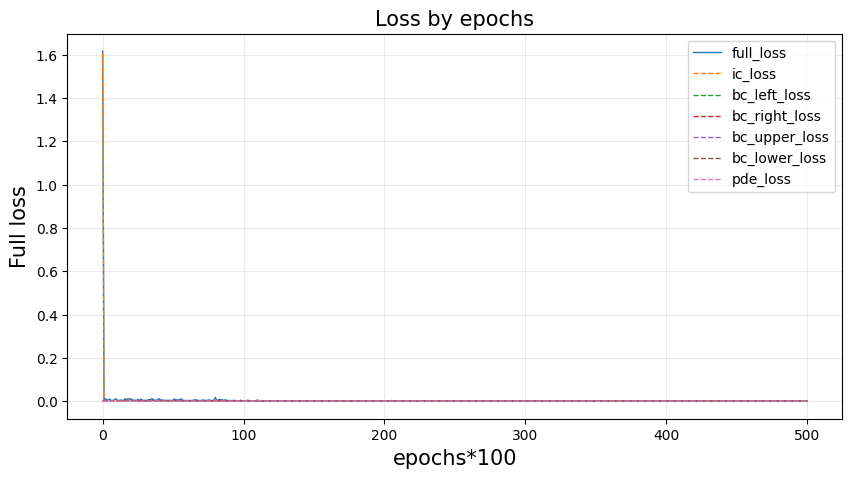

In [66]:
plt.style.use('default')
plt.figure(figsize=(10,5))
plt.plot(solver.losses_history, linewidth=1, label='full_loss')
plt.plot(solver.losses_ic_history, linewidth=1, linestyle='dashed', label='ic_loss')
plt.plot(solver.losses_bc_left_history, linewidth=1, linestyle='dashed', label='bc_left_loss')
plt.plot(solver.losses_bc_right_history, linewidth=1, linestyle='dashed', label='bc_right_loss')
plt.plot(solver.losses_bc_upper_history, linewidth=1, linestyle='dashed', label='bc_upper_loss')
plt.plot(solver.losses_bc_lower_history, linewidth=1, linestyle='dashed', label='bc_lower_loss')
plt.plot(solver.losses_pde_history, linewidth=1, linestyle='dashed', label='pde_loss')
plt.title('Loss by epochs', fontsize=15)
plt.ylabel('Full loss', fontsize=15)
plt.xlabel('epochs*100', fontsize=15)
plt.legend()
plt.grid(alpha=0.25)

plt.show()

## Temperature distribution in the plate

In [81]:
def solutions_by_t(t, x_left, x_right, y_left, y_right, phi=np.pi/3):
    """
    here we have to create mesh (x,y,t) and calculate temperature distribution for each point
    then we can plot the results by using heatmap or contour plot
    """
    assert x_left < x_right, 'x_left > x_right'
    assert y_left < y_right, 'y_left > y_right'
    lx = x_right - x_left
    ly = y_right - y_left
    x_left /= lx
    x_right /= lx
    y_left /= ly
    y_right /= ly
    step_x = (x_right - x_left) / 500
    step_y = (y_right - y_left) / 500
    x = np.arange(x_left, x_right+step_x, step_x)
    y = np.arange(y_left, y_right+step_y, step_y)
    mesh_x, mesh_y = np.meshgrid(x, y)
    x = np.ravel(mesh_x)
    y = np.ravel(mesh_y)
    crho = 1500000
    # l11 = (20 * np.cos(phi) ** 2 + 1 * np.sin(phi) ** 2)
    # t0 = (crho * ly**2) / l11
    l22 = (20 * np.sin(phi) ** 2 + 1 * np.cos(phi) ** 2)
    t0 = (crho * ly**2) / l22
    tensor_x = torch.FloatTensor(x.reshape(-1,1)).requires_grad_(requires_grad=False).to(device)
    tensor_y = torch.FloatTensor(y.reshape(-1,1)).requires_grad_(requires_grad=False).to(device)
    tensor_t = (t / t0) * torch.ones(tensor_x.shape[0], 1, requires_grad=False).to(device)
    l11 = (20 * np.cos(phi) ** 2 + 1 * np.sin(phi) ** 2) * torch.ones_like(tensor_x, requires_grad=False).to(device)
    l12 = ((20 - 1) * np.sin(phi) * np.cos(phi)) * torch.ones_like(tensor_x, requires_grad=False).to(device)
    l22 = (20 * np.sin(phi) ** 2 + 1 * np.cos(phi) ** 2) * torch.ones_like(tensor_x, requires_grad=False).to(device)
    with torch.no_grad():
        u_net = (solver.net(l11, l12, l22, tensor_x, tensor_y, tensor_t).detach().cpu().numpy()).reshape(mesh_x.shape)
    return u_net

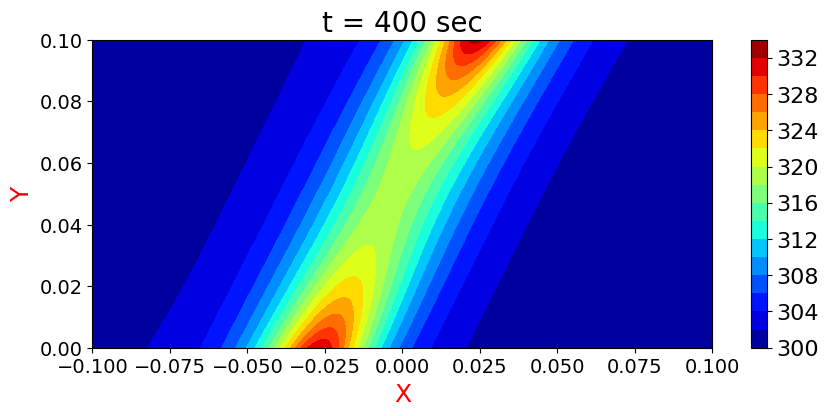

In [80]:
phi=np.pi/3 # let phi=pi/3, but you can choose any from (pi/4, pi/2)
step_x = (x_right - x_left) / 500
step_y = (y_right - y_left) / 500
x = np.arange(x_left, x_right+step_x/2, step_x)
y = np.arange(y_left, y_right+step_y/2, step_y)
mesh_x, mesh_y = np.meshgrid(x, y)
x = np.ravel(mesh_x)
y = np.ravel(mesh_y)
fig = plt.figure(figsize=(10,4))
sol = 300*solutions_by_t(t=400, x_left=x_left, x_right=x_right, y_left=y_left, y_right=y_right, phi=phi)
contours = plt.contourf(mesh_x, mesh_y, sol, 20, cmap='jet')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.title("t = 400 sec", fontsize=20)
plt.xlabel("X", fontsize=18, c='r')
plt.ylabel("Y", fontsize=18, c='r')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig.savefig('task8densitypi6.png', bbox_inches='tight')

In [75]:
times = [0.0, 400, 983]
solutions = []

for i in range(len(times)):
    solutions.append(300*solutions_by_t(times[i], x_left=x_left, x_right=x_right, y_left=y_left, y_right=y_right, phi=phi))

In [76]:
times_anim = np.arange(0.0, 400+20, 20)
solutions_anim = []

for i in range(len(times_anim)):
    solutions_anim.append(solutions_by_t(times_anim[i], x_left=x_left, x_right=x_right, y_left=y_left, y_right=y_right, phi=phi))

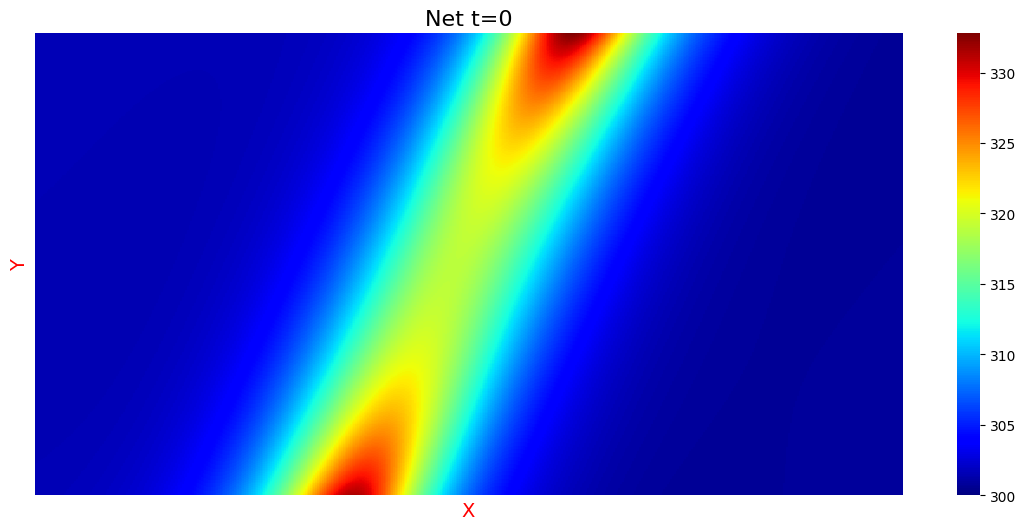

In [77]:
fig = plt.figure(figsize=(14,6))

ax = sns.heatmap(300*solutions_anim[20], vmin=300, vmax=300*solutions_anim[20].max(), cmap="jet", xticklabels=False, yticklabels=False)
ax.invert_yaxis()

def init():
    ax = sns.heatmap(300*solutions_anim[20], vmin=300, vmax=300*solutions_anim[20].max(), cbar=False, cmap="jet", xticklabels=False, yticklabels=False)
    ax.invert_yaxis()
    plt.title("Net t=0", fontsize=16)
    plt.xlabel("X", fontsize=14, c='r')
    plt.ylabel("Y", fontsize=14, c='r')

def animate(i):
    sns.heatmap(300*solutions_anim[i], vmin=300, vmax=300*solutions_anim[20].max(), cbar=False, cmap="jet", xticklabels=False, yticklabels=False)
    ax.invert_yaxis()
    plt.title("t="+str(i*20)+" c.", fontsize=16)
    plt.xlabel("X", fontsize=14, c='r')
    plt.ylabel("Y", fontsize=14, c='r')


anim = animation.FuncAnimation(fig, animate, init_func=init, frames=21, repeat=True)

savefile = r"animation_lambda_pi3.gif"
pillowwriter = animation.PillowWriter(fps=4)
anim.save(savefile, writer=pillowwriter)